# NLP Disaster Tweets Kaggle Mini-Project

## Introduction

In this project, we use the dataset provided by Kaggle from the "Getting Started" competition(https://www.kaggle.com/competitions/nlp-getting-started/overview). The aim of this project is to build a RNN model to classify tweets as either "disaster" or "not disaster". The data consists of 7613 tweets for training and 3263 tweets for testing. There are 5 features for the training data which are id, keyword, location, text and target. We will be predicting the target variable for test data. 

Natural Language Processing(NLP) helps machines understand human language. NLP is used in many real-world applications such as Google Translate, virtual agents such as Apple's Siri, Chatbots and sentiment analysis. We will use NLP techniques to help computers read the tweet texts and provide a sentiment analysis which in this case is whether the tweet is a disaster-related or not.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam

In [2]:
train_data = pd.read_csv("./Data/train.csv")
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train_data.shape

(7613, 5)

In [4]:
train_data.describe(include = 'all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [5]:
test_data = pd.read_csv("./Data/test.csv")
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
test_data.shape

(3263, 4)

In [7]:
test_data.describe(include = 'all')

,id,keyword,location,text
count,3263.000000,3237,2158,3263
unique,NaN,221,1602,3243
top,NaN,deluged,New York,11-Year-Old Boy Charged With Manslaughter of T...
freq,NaN,23,38,3
mean,5427.152927,NaN,NaN,NaN
std,3146.427221,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,2683.000000,NaN,NaN,NaN
50%,5500.000000,NaN,NaN,NaN
75%,8176.000000,NaN,NaN,NaN


In [8]:
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
test_data.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

## Data Cleaning and Exploratory Data Analysis 

In the training data, there 7613 rows in which the attributes id, text and target have no missing values. From above, we can see that keyword has 61 missing observations and location has 2533 missing values. In the test data as well, keyword and location have 26 and 1105 missing values, respectively. We will drop the features keyword and location from the datasets so that we don't have to manipulate missing values for our model.

In [10]:
train_data = train_data.drop(['keyword', 'location'], axis = 1)
test_data = test_data.drop(['keyword', 'location'], axis = 1)

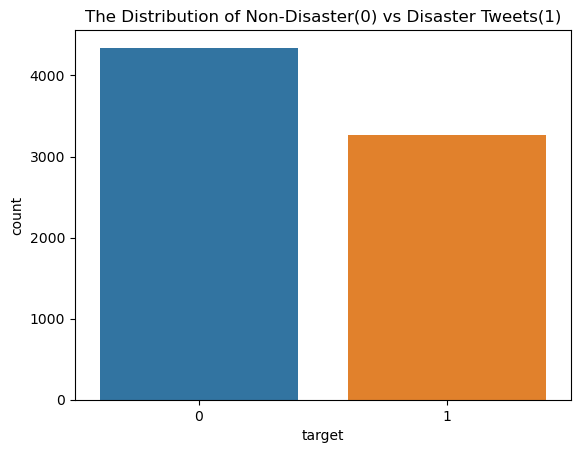

In [11]:
fig, ax = plt.subplots()
ax = sns.countplot(x = train_data['target'])
plt.title("The Distribution of Non-Disaster(0) vs Disaster Tweets(1)")
plt.show()

In [12]:
print('Target distribution(%):') 
print(np.round(train_data['target'].value_counts(normalize=True)*100, 2))

Target distribution(%):
0    57.03
1    42.97
Name: target, dtype: float64


From the above graph, we can see there are slightly more non-disaster tweets than disaster tweets. However, after comparing the percentage of target distribution, the data seems relatively balanced. 

Let's see the text content for a disaster tweet and a non-disaster tweet.

In [13]:
#Disaster Tweet
disaster_tweets = train_data[train_data['target']==1]['text']
print(disaster_tweets.values[0])
print(disaster_tweets.values[1])
print(disaster_tweets.values[2])
print(disaster_tweets.values[3])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 


In [14]:
#Non-Disaster Tweet
non_disaster_tweets = train_data[train_data['target']==0]['text']
print(non_disaster_tweets.values[0])
print(non_disaster_tweets.values[1])
print(non_disaster_tweets.values[2])
print(non_disaster_tweets.values[3])

What's up man?
I love fruits
Summer is lovely
My car is so fast


Comparing the distribution of characters in disaster tweets and non-disaster tweets, we can see that the number of characters in disaster tweets is relatively higher than the number of characters in non-disaster tweets.

In [15]:
print("Number of Characters in Disaster Tweets")
print("Min:", min(disaster_tweets.str.len()))
print("Max:", max(disaster_tweets.str.len()))
print("Mean:", np.round(np.mean(disaster_tweets.str.len()), 2))

Number of Characters in Disaster Tweets
Min: 14
Max: 151
Mean: 108.11


In [16]:
print("Number of Characters in Non-Disaster Tweets")
print("Min:", min(non_disaster_tweets.str.len()))
print("Max:", max(non_disaster_tweets.str.len()))
print("Mean:", np.round(np.mean(non_disaster_tweets.str.len()), 2))

Number of Characters in Non-Disaster Tweets
Min: 7
Max: 157
Mean: 95.71


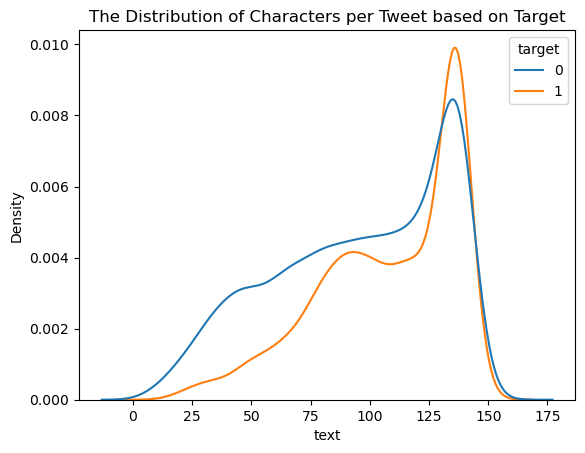

In [17]:
# Visualizing number of characters in each tweet
fig, ax = plt.subplots()
ax = sns.kdeplot(train_data, x = train_data['text'].str.len(), hue = 'target')
plt.title("The Distribution of Characters per Tweet based on Target")
plt.show()

Comparing the distribution of words in disaster and non-disaster tweets, we can see that the word distribution is similar in both types of tweets.

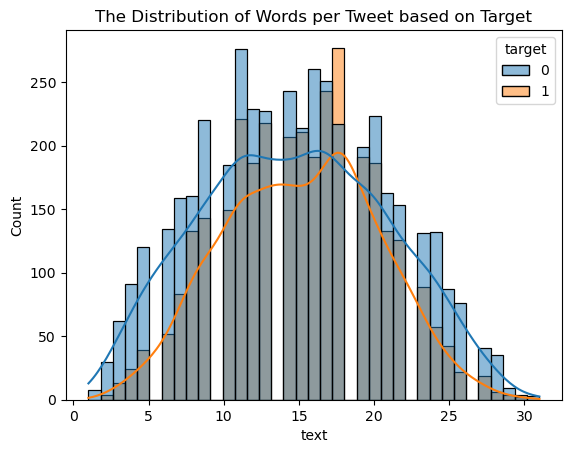

In [18]:
# Visualizing number of words in each Category
train_data['text'].str.split().map(lambda x: len(x))

fig, ax = plt.subplots()
ax = sns.histplot(train_data, x = train_data['text'].str.split().map(lambda x: len(x)), hue = train_data['target'], kde = True)
plt.title("The Distribution of Words per Tweet based on Target")
plt.show()

We will apply NLP techniques on the text data so that it will easier for the model to analyse and predict the target variable.

## Text Preprocessing

To make the text more readable, we have to make sure the text is all lowercase and remove special characters such as hashtags etc. Then we will remove stopwords. Here, the stopwords are commonly used words in English. By removing them, we can focus on more important words in the text.

In [19]:
#References #2, #13
#Lowercase all text
train_data["text"] = train_data["text"].str.lower()

#Remove numeric and special characters, including punctuation
train_data["text"] = train_data["text"].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
train_data["text"] = train_data["text"].apply(lambda row: re.sub(r'[0-9]', '', row))

In [20]:
#Remove stopwords
stopwords = nltk.corpus.stopwords.words('english')

train_data["text"] = train_data["text"].apply(lambda words: ' '.join(word for word in words.split() if word not in stopwords))

In [21]:
train_data.head()

,id,text,target
0,1,deeds reason earthquake may allah forgive us,1
1,4,forest fire near la ronge sask canada,1
2,5,residents asked shelter place notified officer...,1
3,6,people receive wildfires evacuation orders cal...,1
4,7,got sent photo ruby alaska smoke wildfires pou...,1


Next, we will tokenize and lemmatize the text.

Tokenization is a technique to break down sentences into a stream of words called tokens. This can be used for further analysis or in other methods for natural language processing.

Lemmatization is text preprocessing technique similar to stemming since they can be used to convert words into their root form. Lemmatization is more advanced since it actually transforms the word to its actual root by using a dictionary. Because it tries to be more accurate, it requires more processing power and time to generate an output. However since I'm trying to classify tweets, it would be better to have more accurate conversions of the word to its root.

In [22]:
#References #5, #6
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatizer(text):
    tokens = nltk.word_tokenize(text)
    lem_text = ' '.join([wordnet_lemmatizer.lemmatize(w) for w in tokens])
    return lem_text

In [23]:
train_data["text"] = train_data["text"].apply(lemmatizer)

In [24]:
train_data["text"].head()

0           deed reason earthquake may allah forgive u
1                forest fire near la ronge sask canada
2    resident asked shelter place notified officer ...
3    people receive wildfire evacuation order calif...
4    got sent photo ruby alaska smoke wildfire pour...
Name: text, dtype: object

## Feature Extraction 

### TF-IDF Vectorizer

#### Brief Summary about TF-IDF 

Term Frequency - Inverse Document Frequency, or TF-IDF, is a measure used to evaluate how meaningful a word is to a document among a collection of documents. It vectorizes a word by multiplying the word's Term Frequency (TF) with the Inverse Document Frequency (IDF).

**TF** = No. of times a certain word appears in document. 

**IDF** = Weight of the term or the measure of how common or uncommon the word is across the entire set of documents. In sklearn, IDF is calculated by:

$$IDF(t) = \log \frac{(1+n)}{1 + DF(t)} + 1$$
where, 
- ***t*** = term that is being measured 
- ***n*** = number of total documents in the corpus 
- ***DF(t)*** = Number of documents in which term, t appears 
      
The TF-IDF score is between 0 and 1. The more relevant the term, the higher TF-IDF value (approaching 1).

In this next step, we will be using sklearn's TF-IDF Vectorizer for processing raw text to feature vectors. By doing this, it will distinguish how relevant a term is to a document proportional to it's importance across all documents in the corpus. This can help distinguish the top words in each category which can help with further classification.

In [25]:
#Initialise the vectorizer
tfidf_vec = TfidfVectorizer(max_features = 1000)

#convert text to matrix form
tfidf_vec.fit(train_data["text"])

features = tfidf_vec.transform(train_data["text"]).toarray()

features.shape

(7613, 1000)

In [26]:
#set labels to target column in train_data
labels = train_data["target"] 

labels.shape

(7613,)

In [27]:
#https://stackoverflow.com/questions/52182185/how-to-use-tf-idf-vectorizer-with-lstm-in-keras-python
features = features[:, :, None] 

In [28]:
#Split dataset into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size = 0.1, random_state = 1)

## Model Building

For the initial model, we will modify the model used in the tensorflow tutorial for RNN text classification(https://www.tensorflow.org/text/tutorials/text_classification_rnn). Our model has 2 Bidirectional LSTM Layers and uses the TF-IDF vectors.

### Initial Model

In [29]:
#Define model
model = Sequential([
    LSTM(64, input_shape = X_train.shape[1:], return_sequences=True),
    Dense(64, activation='sigmoid'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#Compile model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

In [30]:
# summarize model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 64)          16896     
                                                                 
 dense (Dense)               (None, 1000, 64)          4160      
                                                                 
 dropout (Dropout)           (None, 1000, 64)          0         
                                                                 
 dense_1 (Dense)             (None, 1000, 1)           65        
                                                                 
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________


In [31]:
# fit model
history = model.fit(X_train,y_train, validation_data=(X_valid,y_valid), epochs = 10)

Epoch 1/10
215/215 [==============================] - 102s 466ms/step - loss: 0.7613 - accuracy: 0.4990 - val_loss: 0.6829 - val_accuracy: 0.5706
Epoch 2/10
215/215 [==============================] - 96s 448ms/step - loss: 0.7323 - accuracy: 0.5245 - val_loss: 0.6827 - val_accuracy: 0.5709
Epoch 3/10
215/215 [==============================] - 99s 460ms/step - loss: 0.7256 - accuracy: 0.5277 - val_loss: 0.6831 - val_accuracy: 0.5711
Epoch 4/10
215/215 [==============================] - 99s 460ms/step - loss: 0.7150 - accuracy: 0.5332 - val_loss: 0.6828 - val_accuracy: 0.5709
Epoch 5/10
215/215 [==============================] - 99s 459ms/step - loss: 0.7020 - accuracy: 0.5370 - val_loss: 0.6827 - val_accuracy: 0.5717
Epoch 6/10
215/215 [==============================] - 101s 471ms/step - loss: 0.6953 - accuracy: 0.5442 - val_loss: 0.6825 - val_accuracy: 0.5721
Epoch 7/10
215/215 [==============================] - 102s 473ms/step - loss: 0.6919 - accuracy: 0.5524 - val_loss: 0.6827 - val

### Model Results and Analysis

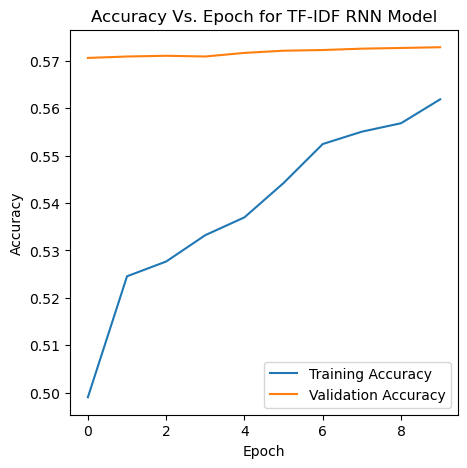

In [32]:
plt.figure(figsize=(5, 5))
plt.plot(history.history["accuracy"], zorder = 0, label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], zorder = 1, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs. Epoch for TF-IDF RNN Model")
plt.show()

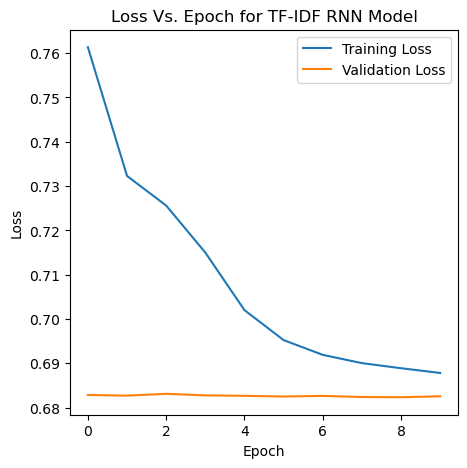

In [33]:
plt.figure(figsize=(5, 5))
plt.plot(history.history["loss"], zorder = 0, label = "Training Loss")
plt.plot(history.history["val_loss"], zorder = 1, label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Vs. Epoch for TF-IDF RNN Model")
plt.show()

#### Model Comments

The RNN model with TF-IDF does not seem like a good fit for the data. From the above graphs, we can see that the model does well with the training set, but does poorly with the validation set. The accuracy and loss for the validation set seem to be stagnant.

### Alternate Model

Instead of using TF-IDF for word embedding, we will use the Embedding Layer provided by Keras. The Embedding Layer can be used to train our own embeddings. It enables us to convert each word into a fixed length vector of defined size. 

The requirement is that the input text data should be numerical encoded, so that each word is represented by a unique integer. This can be prepared by using the keras.Tokenizer.

In [34]:
X = train_data['text']
y = train_data['target']
X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.10, random_state=41)

In [35]:
#References #14, #15
t = Tokenizer(num_words = 10000)
t.fit_on_texts(X_tr)

In [36]:
encoded_train = t.texts_to_sequences(X_tr)
encoded_test = t.texts_to_sequences(X_tst)
print(encoded_train[0:2])

[[5655, 5656, 55, 367, 456, 37, 3762, 6, 1053, 694, 287], [243, 305, 5657, 774, 1, 5658, 2]]


In [37]:
max_length = 25
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post', truncating='post')
print(padded_train)

[[5655 5656   55 ...    0    0    0]
 [ 243  305 5657 ...    0    0    0]
 [  12   84   85 ...    0    0    0]
 ...
 [5353  182  118 ...    0    0    0]
 [   5 5436 5358 ...    0    0    0]
 [2190   27  991 ...    0    0    0]]


In this RNN model architecture, we will use 2 Bidirectional LSTM layers.

In [38]:
# define model
model1 = Sequential()
model1.add(Embedding(10000, 128))
model1.add(tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)))
model1.add(tf.keras.layers.Bidirectional(LSTM(64)))
model1.add(Dense(128, activation = 'relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

# compile model
model1.compile(loss = 'binary_crossentropy', optimizer=Adam(1e-4), metrics = ['accuracy'])

# summarize model
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [39]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,  mode='min')

In [40]:
#fit model
hist = model1.fit(padded_train,y_tr, validation_data=(padded_test,y_tst), epochs = 100, callbacks=[early_stopping])

Epoch 1/100
215/215 [==============================] - 25s 87ms/step - loss: 0.6708 - accuracy: 0.5856 - val_loss: 0.6176 - val_accuracy: 0.6969
Epoch 2/100
215/215 [==============================] - 16s 75ms/step - loss: 0.4509 - accuracy: 0.8009 - val_loss: 0.4309 - val_accuracy: 0.8163
Epoch 3/100
215/215 [==============================] - 17s 77ms/step - loss: 0.3168 - accuracy: 0.8734 - val_loss: 0.4490 - val_accuracy: 0.8215
Epoch 4/100
215/215 [==============================] - 17s 80ms/step - loss: 0.2441 - accuracy: 0.9101 - val_loss: 0.4960 - val_accuracy: 0.7887
Epoch 5/100
215/215 [==============================] - 18s 82ms/step - loss: 0.1961 - accuracy: 0.9315 - val_loss: 0.5765 - val_accuracy: 0.7966
Epoch 6/100
215/215 [==============================] - 16s 77ms/step - loss: 0.1560 - accuracy: 0.9441 - val_loss: 0.6784 - val_accuracy: 0.7900
Epoch 7/100
215/215 [==============================] - 15s 72ms/step - loss: 0.1269 - accuracy: 0.9561 - val_loss: 0.7328 - val_ac

### Model Results and Analysis

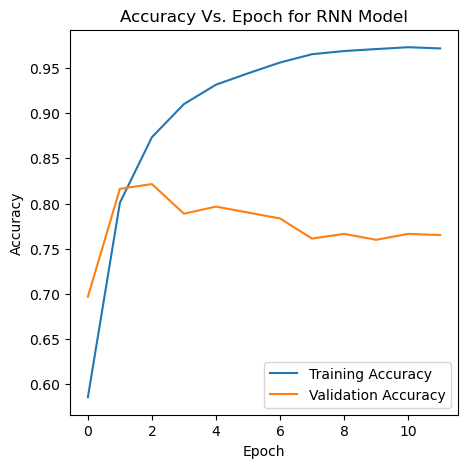

In [41]:
plt.figure(figsize=(5, 5))
plt.plot(hist.history["accuracy"], zorder = 0, label = "Training Accuracy")
plt.plot(hist.history["val_accuracy"], zorder = 1, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs. Epoch for RNN Model")
plt.show()

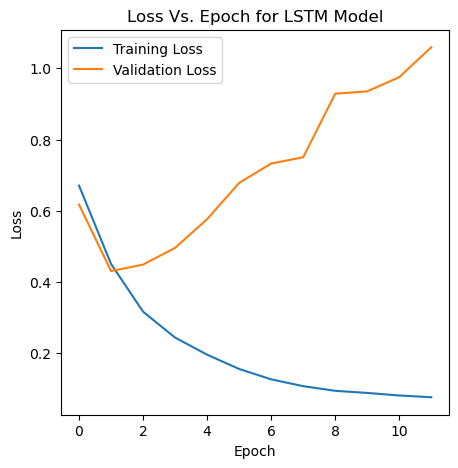

In [42]:
plt.figure(figsize=(5, 5))
plt.plot(hist.history["loss"], zorder = 0, label = "Training Loss")
plt.plot(hist.history["val_loss"], zorder = 1, label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Vs. Epoch for LSTM Model")
plt.show()

In [43]:
from sklearn import metrics

y_pred = model1.predict(padded_test).round()

24/24 [==============================] - 2s 16ms/step


In [44]:
train_accuracy = metrics.accuracy_score(y_tr, model1.predict(padded_train).round())*100
train_accuracy

215/215 [==============================] - 4s 21ms/step


98.13165961173551

In [45]:
test_accuracy = metrics.accuracy_score(y_tst, y_pred)*100
test_accuracy

76.50918635170603

In [46]:
print(metrics.classification_report(y_tst, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       437
           1       0.73      0.71      0.72       325

    accuracy                           0.77       762
   macro avg       0.76      0.76      0.76       762
weighted avg       0.76      0.77      0.76       762



### Hyperparameter Tuning

The Keras Tuner library that helps with hyperparameter optimization for tensorflow applications(https://www.tensorflow.org/tutorials/keras/keras_tuner). We will use it to find the best hyperparameters for our Bidirectional RNN Model. 

In [47]:
import keras_tuner as kt

In [48]:
def model_builder(hp):
    model2 = Sequential()
    model2.add(Embedding(10000, 128))
    model2.add(tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)))
    model2.add(tf.keras.layers.Bidirectional(LSTM(64)))
    model2.add(Dense(128, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model2.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model2.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
   
    model2.compile(loss='binary_crossentropy', optimizer=Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])), metrics=['accuracy'])
    
    return model2
    
tuner = kt.RandomSearch(model_builder, objective='accuracy', max_trials=4, executions_per_trial=2)

tuner.search(x=padded_train, y=y_tr, epochs = 100, validation_data=(padded_test, y_tst), callbacks=[early_stopping])

Trial 4 Complete [00h 09m 48s]
accuracy: 0.9622682631015778

Best accuracy So Far: 0.9764268100261688
Total elapsed time: 00h 33m 30s
INFO:tensorflow:Oracle triggered exit


In [49]:
best_model = tuner.get_best_models(num_models=1)[0]

In [50]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="accuracy", direction="max")

Trial 2 summary
Hyperparameters:
dense_activation: sigmoid
Dropout_rate: 0.0
learning_rate: 0.01
Score: 0.9764268100261688

Trial 0 summary
Hyperparameters:
dense_activation: sigmoid
Dropout_rate: 0.2
learning_rate: 0.01
Score: 0.9735804796218872

Trial 3 summary
Hyperparameters:
dense_activation: relu
Dropout_rate: 0.1
learning_rate: 0.0001
Score: 0.9622682631015778

Trial 1 summary
Hyperparameters:
dense_activation: relu
Dropout_rate: 0.30000000000000004
learning_rate: 0.0001
Score: 0.955991804599762


In [51]:
#Retrain Model with Best Hyperparameters
final_model = Sequential()
final_model.add(Embedding(10000, 128))
final_model.add(tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)))
final_model.add(tf.keras.layers.Bidirectional(LSTM(64)))
final_model.add(Dense(128, activation = 'sigmoid'))
final_model.add(Dropout(0.0))
final_model.add(Dense(1, activation='sigmoid'))

# compile model
final_model.compile(loss = 'binary_crossentropy', optimizer=Adam(0.01), metrics = ['accuracy'])

# summarize model
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 256)        263168    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [52]:
final_hist = final_model.fit(padded_train,y_tr, validation_data=(padded_test,y_tst), epochs = 100, callbacks=[early_stopping])

Epoch 1/100
215/215 [==============================] - 23s 83ms/step - loss: 0.5177 - accuracy: 0.7530 - val_loss: 0.4472 - val_accuracy: 0.8031
Epoch 2/100
215/215 [==============================] - 20s 94ms/step - loss: 0.3071 - accuracy: 0.8822 - val_loss: 0.4651 - val_accuracy: 0.7874
Epoch 3/100
215/215 [==============================] - 19s 89ms/step - loss: 0.2098 - accuracy: 0.9223 - val_loss: 0.5643 - val_accuracy: 0.7966
Epoch 4/100
215/215 [==============================] - 19s 88ms/step - loss: 0.1459 - accuracy: 0.9453 - val_loss: 0.7066 - val_accuracy: 0.7598
Epoch 5/100
215/215 [==============================] - 21s 96ms/step - loss: 0.1007 - accuracy: 0.9591 - val_loss: 0.7578 - val_accuracy: 0.7520
Epoch 6/100
215/215 [==============================] - 20s 93ms/step - loss: 0.0885 - accuracy: 0.9635 - val_loss: 0.8166 - val_accuracy: 0.7717
Epoch 7/100
215/215 [==============================] - 20s 95ms/step - loss: 0.0762 - accuracy: 0.9673 - val_loss: 0.9124 - val_ac

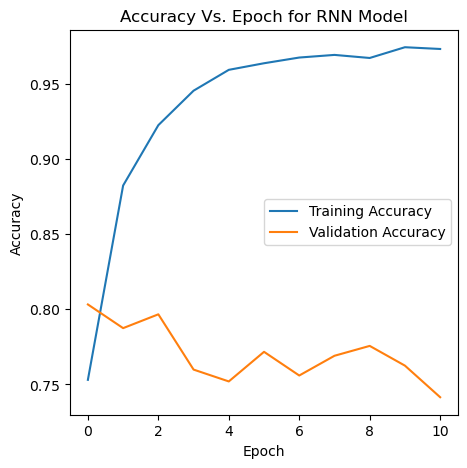

In [53]:
plt.figure(figsize=(5, 5))
plt.plot(final_hist.history["accuracy"], zorder = 0, label = "Training Accuracy")
plt.plot(final_hist.history["val_accuracy"], zorder = 1, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs. Epoch for RNN Model")
plt.show()

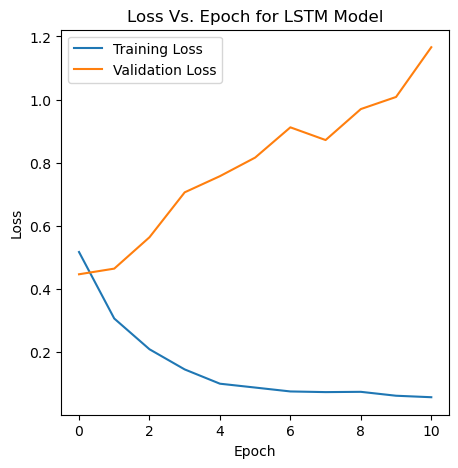

In [54]:
plt.figure(figsize=(5, 5))
plt.plot(final_hist.history["loss"], zorder = 0, label = "Training Loss")
plt.plot(final_hist.history["val_loss"], zorder = 1, label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Vs. Epoch for LSTM Model")
plt.show()

In [55]:
yhat_pred = final_model.predict(padded_test).round()

24/24 [==============================] - 2s 25ms/step


In [56]:
train_accuracy = metrics.accuracy_score(y_tr, final_model.predict(padded_train).round())*100
train_accuracy

215/215 [==============================] - 5s 24ms/step


97.7521529703693

In [57]:
print(metrics.classification_report(y_tst, yhat_pred))

              precision    recall  f1-score   support

           0       0.80      0.73      0.76       437
           1       0.67      0.76      0.72       325

    accuracy                           0.74       762
   macro avg       0.74      0.74      0.74       762
weighted avg       0.75      0.74      0.74       762



### Model Commentary

The Bidirectional RNN model without TF-IDF is much better than the RNN model with TF-IDF. Encoding the training data and using the Embedding layer to train our own word embeddings improved the performance and timing of the model significantly. Initially I trained the model with one LSTM layer like the first RNN model with TF-IDF. The performance was good, but by using two bidirectional LSTM layers improved the accuracy of the training set and validation set. After hyperparameter tuning, I found that the best hyperparameters for the model is dense activation = 'sigmoid', Dropout rate = 0.0 and learning rate = 0.01.

## Test Data Submission

In [58]:
#Clean Test Data
#Lowercase all text
test_data["text"] = test_data["text"].str.lower()

#Remove numeric and special characters, including punctuation
test_data["text"] = test_data["text"].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
test_data["text"] = test_data["text"].apply(lambda row: re.sub(r'[0-9]', '', row))

#Remove stopwords
test_data["text"] = test_data["text"].apply(lambda words: ' '.join(word for word in words.split() if word not in stopwords))

#Lemmatization
test_data["text"] = test_data["text"].apply(lemmatizer)

test_data.head()

,id,text
0,0,happened terrible car crash
1,2,heard earthquake different city stay safe ever...
2,3,forest fire spot pond goose fleeing across str...
3,9,apocalypse lighting spokane wildfire
4,11,typhoon soudelor kill china taiwan


In [59]:
encoded_test_data = t.texts_to_sequences(test_data["text"])

In [60]:
padded_test_data = pad_sequences(encoded_test_data, maxlen=max_length, padding='post', truncating='post')

In [61]:
#RNN model without TF-IDF
predictions = model1.predict(padded_test_data).round()

102/102 [==============================] - 3s 23ms/step


In [62]:
submission = pd.read_csv("C:/Users/venuk/Desktop/dtsa-5511/week4/NLP_Disaster_Tweets/sample_submission.csv")
submission['target'] = np.round(predictions).astype('int')
#submission.to_csv('submission.csv', index=False)

In [63]:
#RNN model with best hyperparameters and without TF-IDF 
final_predictions = final_model.predict(padded_test_data).round()

102/102 [==============================] - 2s 24ms/step


In [64]:
submission1 = pd.read_csv("C:/Users/venuk/Desktop/dtsa-5511/week4/NLP_Disaster_Tweets/sample_submission.csv")
submission1['target'] = np.round(final_predictions).astype('int')
#submission.to_csv('submission1.csv', index=False)

## Conclusion

In this project, I compared two model architectures. One used TF-IDF for word embeddings and the other used the Embedded Layer provided by Keras. The first model using TF-IDF didn't do so well with the max training accuracy of 56% and max validation accuracy of 57%. The model also required more time for training even though I used a single LSTM layer.

The second model architecture was more complex than the first model. This model did not use the TF-IDF vectors. Instead, we encoded the text from the training data using the Keras Tokenizer and also used an Embedding Layer in our model. The Embedding layer takes the encoded data as input and converts it into fixed length vectors for each word. I used two bidirectional LSTM layers in the model. The performance of this model improved greatly from the previous model. It had a max training accuracy of 98.1% and a max validation accuracy of 76.5%. After using the best hyperparameters found during hyperparameter optimization, the model still performed well, but the max training accuracy and max validation accuracy fell to 97.7% and 74% respectively.

In the future, I would like to use pre-trained word embeddings such as GloVe to see if this will improve the model performance. I would also like to use GRU layers instead of LSTM. 

### References

1. https://www.ibm.com/cloud/learn/natural-language-processing
2. https://www.kaggle.com/code/parulpandey/getting-started-with-nlp-a-general-intro
3. https://www.kaggle.com/code/majinx/nlp-eda-tfidf-wordcloud-lemmatization
4. https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
5. https://stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells
6. https://www.kaggle.com/code/astraz93/beginners-tokenization-stemming-and-lemmatization
7. https://towardsdatascience.com/text-preprocessing-in-natural-language-processing-using-python-6113ff5decd8
8. https://www.kaggle.com/code/daotan/tweet-analysis-using-lstm
9. https://www.tensorflow.org/text/tutorials/text_classification_rnn
10. https://www.kaggle.com/code/neerajmohan/nlp-bidirectional-lstm-using-tensorflow-2-0#Tokenization
11. https://www.kaggle.com/code/frankmollard/nlp-a-gentle-introduction-lstm-word2vec-bert
12. https://www.kaggle.com/code/subhadeepdebnath/nlp-disaster-tweets-lstm-complete-guide#Step---2-:-Data-Pre-processing
13. https://towardsdatascience.com/long-short-term-memory-lstm-in-keras-2b5749e953ac
14. https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce
15. https://colab.research.google.com/drive/1CVZ4NTO3NRYNDV1MWxvx5Y5HKtgt0OCo#scrollTo=b537E9We_LWi
16. https://www.tensorflow.org/tutorials/keras/keras_tuner
17. https://medium.com/analytics-vidhya/hypertuning-a-lstm-with-keras-tuner-to-forecast-solar-irradiance-7da7577e96eb